In [1]:
import os
import re
import torch
import torchvision
import mlflow
import random
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

# Special imports of above dependencies:
import torchvision.transforms as T
import torch.nn as NN
import torch.nn.functional as F

# Creating subsets of UTKFace dataset

In [2]:
originalPath = "../data/raw/UTKFace_dataset/" # Path to the original dataset
targetPath = "../data/processed/UTKFace/" # Path to the processed dataset

# Define the category folders:
pathMen = os.path.join(targetPath, "men")
pathWomen  = os.path.join(targetPath, "women")
pathBaby = os.path.join(targetPath, "baby")

# Creaate the category folders if they do not exist:
os.makedirs(pathMen, exist_ok=True)
os.makedirs(pathWomen, exist_ok=True)
os.makedirs(pathBaby, exist_ok=True)

# Define the Regex pattern:
pattern = re.compile(r"^(\d+)_(\d)_(\d)_.*") # Pattern to extract [age: 0-116]_[gender: 0,1]_[ethnicity: 0-4]

# Define counters for every category:
count_men = 0
count_women = 0
count_baby = 0

for i, image_name in enumerate(os.listdir(originalPath)):
    match = pattern.match(image_name)

    if match:
        age = int(match.group(1))
        gender = int(match.group(2))
        race = int(match.group(3))
        

        source = os.path.join(originalPath, image_name)

        # Classification:
        if age <= 3:
            baby_image_name = f"{age}_{gender}_{race}_{count_baby}.jpg"
            destination = os.path.join(pathBaby, baby_image_name)
            shutil.copy(source, destination)
            count_baby += 1

        elif gender == 0 and (age >= 18 and age <= 40):
            men_image_name = f"{age}_{gender}_{race}_{count_men}.jpg"
            destination = os.path.join(pathMen, men_image_name)
            shutil.copy(source, destination)
            count_men += 1

        elif gender == 1 and (age >= 18 and age <= 40):
            women_image_name = f"{age}_{gender}_{race}_{count_women}.jpg"
            destination = os.path.join(pathWomen, women_image_name)
            shutil.copy(source, destination)
            count_women += 1

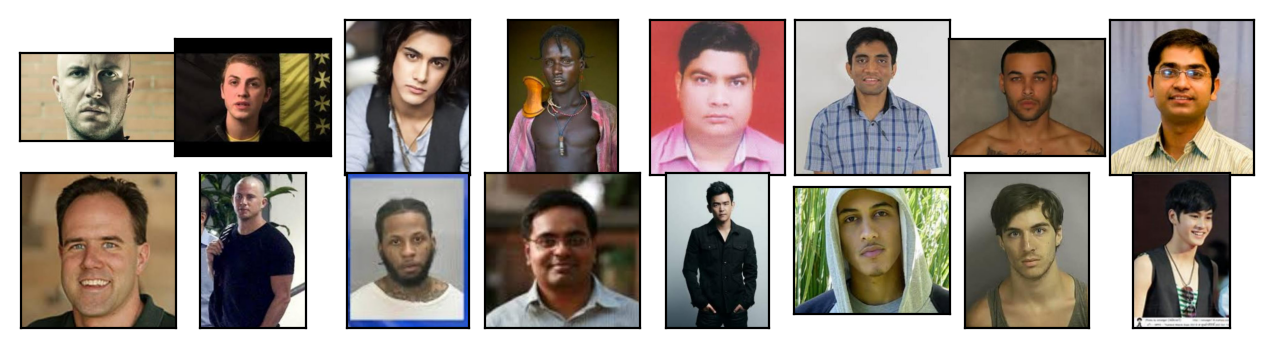

In [3]:
# Showing samples:
random.seed(42) # For reproducibility

imgs_men = os.listdir(pathMen) # Los of men images
imgs_women = os.listdir(pathWomen) # List of women images
imgs_baby = os.listdir(pathBaby) # List of baby images

# Creating random samples per category:
n_samples = 16

samples_men = random.sample(imgs_men, n_samples) # Randomly sample 16 images from men
samples_woman = random.sample(imgs_women, n_samples) # Ramdomly sample 16 imges from women
samples_baby = random.sample(imgs_baby, n_samples) # Randomply sample 16 images from baby

fig = plt.figure(dpi=200, figsize=(8, 2)) # Create a figure

# Showing the 16 images from men
for i in range(n_samples):
    ax = plt.subplot(2, 8, i+1) # Create a subplot
    img = Image.open(f"{pathMen}/{samples_men[i]}") # Open the image
    plt.imshow(img) # Show the image
    plt.xticks([]) # Remove x ticks
    plt.yticks([]) # Remove y ticks
    
plt.subplots_adjust(wspace=-0.01, hspace=-0.01) # Adjust the spacing
plt.show()

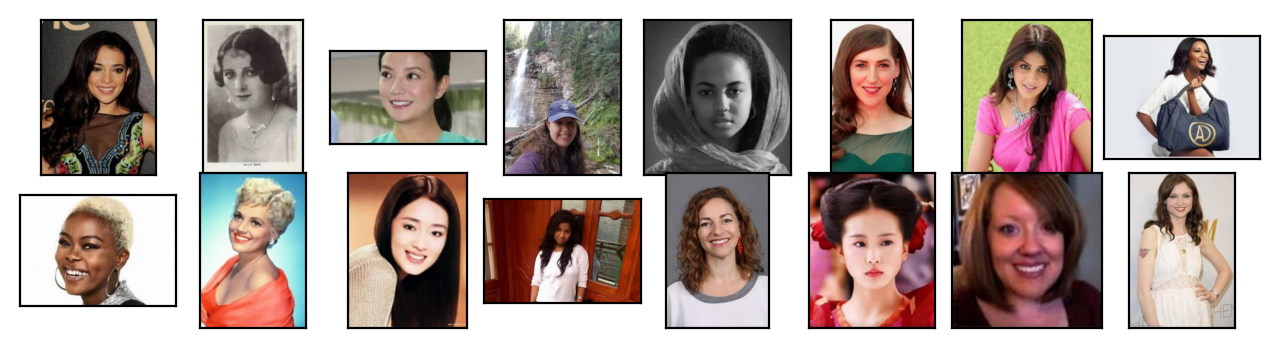

In [4]:
# Showing women samples:
fig = plt.figure(dpi=200, figsize=(8, 2)) # Create a figure

for i in range(n_samples):
    ax = plt.subplot(2, 8, i+1)
    img = Image.open(f"{pathWomen}/{samples_woman[i]}")
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

plt.subplots_adjust(wspace=-0.01, hspace=-0.01)
plt.show()

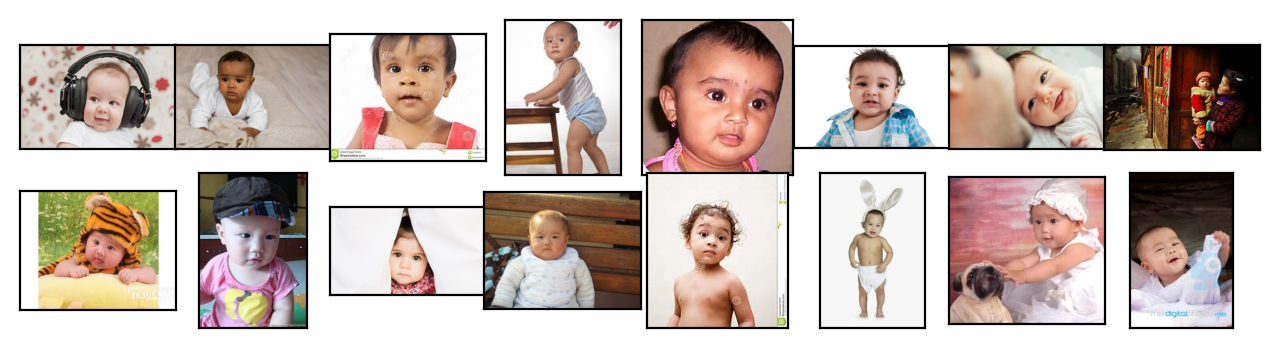

In [5]:
# Showing baby samples:
fig = plt.figure(dpi=200, figsize=(8, 2)) # Create a figure

for i in range(n_samples):
    ax = plt.subplot(2, 8, i+1)
    img = Image.open(f"{pathBaby}/{samples_baby[i]}")
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

plt.subplots_adjust(wspace=-0.01, hspace=-0.01)
plt.show()

# Defining the VAE architecture:

In [6]:
# Detecting if a GPU is available:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device used: {torch.cuda.get_device_name(0)}") if device == "cuda" else print("No GPU available: Using CPU")

Device used: NVIDIA GeForce RTX 5080


In [7]:
# Defining the architecture for the VAE:
class Encoder(NN.Module):
    def __init__(self, latent_dims=100):
        super().__init__()
        # ###########################################
        # ############# Architecture 2: #############
        # ###########################################

        self.conv1 = NN.Conv2d(3, 32, 3, stride=2, padding=1) # Input: 3x256x256 -> Output: 32x128x128
        self.batch1 = NN.BatchNorm2d(32) # Normalization 2D
        self.conv2 = NN.Conv2d(32, 64, 3, stride=2, padding=1) # Input: 32x128,128 -> Output: 64x64x64
        self.batch2 = NN.BatchNorm2d(64) # Normalization 2D
        self.conv3 = NN.Conv2d(64, 128, 3, stride=2, padding=0) # Input: 64x64x64 -> Output: 128x31x31
        self.batch3 = NN.BatchNorm2d(128) # Normalizarion 2D
        self.linear = NN.Linear(31*31*128, 1024) # Fully connected layer
        self.batch_linear = NN.BatchNorm1d(1024) # Normalization 1D

        self.linear_mu = NN.Linear(1024, latent_dims) # Fully connected layer for mean
        self.linear_log_var = NN.Linear(1024, latent_dims) # Fully connected layer for log variance

        self.N = torch.distributions.Normal(0, 1) # Stardard normal distribution
        self.N.loc = self.N.loc.cuda() # Move to GPU if available
        self.N.scale.cuda() # Move to GPU id available

    def forward(self, x):
        x = x.to(device) # Move input to GPU or CPU
        x = F.relu(self.batch1(self.conv1(x)))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.batch3(self.conv3(x)))

        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.batch_linear(self.linear(x)))

        mu = self.linear_mu(x) # Compute mean
        log_var = self.linear_log_var(x) # Compute log variance

        return mu, log_var
    
    
class Decoder(NN.Module):
    # Recibe HP_LATENT_DIMS desde el __init__ de VAE
    def __init__(self, latent_dims):
        super().__init__()
        # ###########################################
        # ############# Architecture 2: #############
        # ###########################################

        # --- Linear layers (BatchNorm1d) ---
        self.linear1 = NN.Linear(latent_dims, 1024)
        self.batch_linear1 = NN.BatchNorm1d(1024)
        self.linear2 = NN.Linear(1024, 31*31*128)
        self.batch_linear2 = NN.BatchNorm1d(31*31*128)
        
        self.unflatten = NN.Unflatten(dim=1, unflattened_size=(128, 31, 31))

        # --- ConvTranspose Layers (con BatchNorm2d) ---
        self.convT1 = NN.ConvTranspose2d(128, 64, 3, stride=2, padding=0, output_padding=1)
        self.batchT1 = NN.BatchNorm2d(64)
        self.convT2 = NN.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1)
        self.batchT2 = NN.BatchNorm2d(32)

        # Last layer with no BatchNorm
        self.convT3 = NN.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1)
        
    def forward(self, z):
        z = z.to(device)

        # Lineal
        x = F.relu(self.batch_linear1(self.linear1(z)))
        x = F.relu(self.batch_linear2(self.linear2(x)))
        
        x = self.unflatten(x)
        
        # ConvTranspose
        x = F.relu(self.batchT1(self.convT1(x)))
        x = F.relu(self.batchT2(self.convT2(x)))
        
        # Final Layer:
        x = self.convT3(x) 
        x = torch.sigmoid(x) # Salida [0, 1]

        return x
    

class VAE(NN.Module):
    def __init__(self, latent_dims=100):
        super().__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def reparametrize(self, mu, log_var):
        std = torch.exp(0.5 * log_var) # Compute standard deviation from log variance
        eps = torch.rand_like(std) # Sample form standard normal distribution

        return mu + eps * std
    
    def forward(self, x):
        x = x.to(device)
        mu, log_var = self.encoder(x)
        z = self.reparametrize(mu, log_var)

        return self.decoder(z), mu, log_var

# Defining the training structure

In [8]:
# Define training function:
def train_epoch(beta, kl_threshold, vae_model, loader, optimizer, loss_fnc): # Ahora recibe el threshold
    vae_model.train()
    total_loss, total_recon_loss, total_kl_loss = 0, 0, 0 

    for imgs, _ in loader:
        imgs = imgs.to(device)

        recon_imgs, mu, log_var = vae_model(imgs)
        
        if loss_fnc == "MSE":
            reconstruction_loss = F.mse_loss(recon_imgs, imgs, reduction='mean') # Mean Squared Error loss
        elif loss_fnc == "BCE":
            reconstruction_loss = F.binary_cross_entropy(recon_imgs, imgs, reduction='mean') # Binary Cross Entropy Loss
        else:
            print("Loss function does not exist...")

        kl_div = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())

        kl_penalty = F.relu(kl_div - kl_threshold) # Free bits

        loss = reconstruction_loss + beta * kl_penalty
        optimizer.zero_grad()
        loss.backward() 
        NN.utils.clip_grad_norm_(vae_model.parameters(), max_norm=1.0)
        optimizer.step()

        #Acumulators:
        total_loss += loss.item() * imgs.size(0)
        total_recon_loss += reconstruction_loss.item() * imgs.size(0)
        total_kl_loss += kl_div.item() * imgs.size(0)


    avg_loss = total_loss / len(loader.dataset)
    avg_recon = total_recon_loss / len(loader.dataset)
    avg_kl = total_kl_loss / len(loader.dataset)

    return avg_loss, avg_recon, avg_kl

# Define plot function for reconstructions:
def plot_epoch(save_path=None, latent_dims=100, vae_model=None):
    vae_model.eval()
    with torch.no_grad():
        noise = torch.randn(18, latent_dims).to(device) # Generate random noise in latent space
        imgs = vae_model.decoder(noise).cpu() # Decode the noise to generate images and move to CPU
        imgs = torchvision.utils.make_grid(imgs, 6, 3).numpy() # Arrange images in a grid

        fig, ax = plt.subplots(figsize=(6,3), dpi=100)
        plt.imshow(np.transpose(imgs, (1, 2, 0)))
        plt.axis("off")

        if save_path:
            plt.savefig(save_path, bbox_inches='tight')

        plt.show()
        plt.close(fig)

# Training the VAE model

In [9]:
# MLFlow information:
EXPERIMENT_NAME = "VAE_men_only_v2"
RUN_NAME = "Try: making kl_div more important than recon_loss by increasing max_beta to 10"

# Hyperparams:
HP_LR = 1e-4 # Learning rate
HP_PATIENCE = 3 # Waiting epochs for scheduler_main
HP_N_EPOCHS = 100 # Total training epochs
HP_MAX_BETA = 0.01 # Strenght of Beta-VAE regularization
HP_BATCH_SIZE = 16 # n (inputs) images per batch
HP_LATENT_DIMS = 32 # Size of latent space
HP_START_FACTOR = 0.01 # Start % of HP_LR in scheduler_warmup
HP_WEIGHT_DECAY = 1e-5 # Weight penalization for Adam Optimizer
HP_KL_THRESHOLD = 0.0 # KL Divergence threshold
HP_WARMUP_EPOCHS = 50 # Epochs to set HP_LR
HP_BETA_ANNEALING = 1 # Epochs for beta warming-up
HP_MODEL_ARCH = "Beta-VAE_men_only_v1"
HP_LOSS_FCN = "BCE" # Loss function

In [10]:
# Transforming the data and creating batches for training:
transform = T.Compose([T.Resize((256, 256)), T.ToTensor()]) # Transforming the data into tensors of 256x256 with normalized pixels [0.0 - 1.0]
data = torchvision.datasets.ImageFolder(root=targetPath, transform=transform)

class_map = data.class_to_idx # Maping the the classes of data
targets = torch.tensor(data.targets) # Get the list of all the labels

# Filtering the class 'men':
men_idx = class_map['men']
men_indexes = torch.where(targets == men_idx)[0]
men_dataset = torch.utils.data.Subset(data, men_indexes)

men_loader = torch.utils.data.DataLoader(men_dataset, batch_size=HP_BATCH_SIZE, shuffle=True)

#loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True) # All classes loader

In [11]:
# Initialize VAE model and move it to the device
vae = VAE(HP_LATENT_DIMS).to(device)

# Define optimizer and schedulers:
optimizer = torch.optim.Adam(vae.parameters(), lr=HP_LR, weight_decay=HP_WEIGHT_DECAY) # Adam Optimizer
scheduler_warmup = torch.optim.lr_scheduler.LinearLR(
    optimizer,
    start_factor=HP_START_FACTOR,
    total_iters=HP_WARMUP_EPOCHS
)
scheduler_main = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'min',
    patience=HP_PATIENCE,
)

Logging parameters to MLFlow...
Starting MLFlow Run: Try: making kl_div more important than recon_loss by increasing max_beta to 10
Epoch 0 | Avg Loss: 0.7260 | Recon Loss: 0.7260 | KL Div: 121109.9315 | Beta: 0.0000 | Current LR: 0.000001


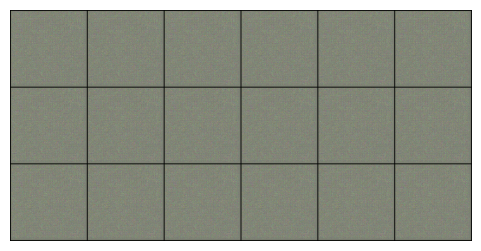

Epoch 1 | Avg Loss: 103.7984 | Recon Loss: 0.7084 | KL Div: 10309.0029 | Beta: 0.0100 | Current LR: 0.000003
Epoch 2 | Avg Loss: 0.6789 | Recon Loss: 0.6763 | KL Div: 0.2670 | Beta: 0.0100 | Current LR: 0.000005
Epoch 3 | Avg Loss: 0.6530 | Recon Loss: 0.6507 | KL Div: 0.2291 | Beta: 0.0100 | Current LR: 0.000007
Epoch 4 | Avg Loss: 0.6305 | Recon Loss: 0.6279 | KL Div: 0.2550 | Beta: 0.0100 | Current LR: 0.000009
Epoch 5 | Avg Loss: 0.6102 | Recon Loss: 0.6072 | KL Div: 0.2929 | Beta: 0.0100 | Current LR: 0.000011
Epoch 6 | Avg Loss: 0.5953 | Recon Loss: 0.5919 | KL Div: 0.3390 | Beta: 0.0100 | Current LR: 0.000013
Epoch 7 | Avg Loss: 0.5857 | Recon Loss: 0.5819 | KL Div: 0.3774 | Beta: 0.0100 | Current LR: 0.000015
Epoch 8 | Avg Loss: 0.5788 | Recon Loss: 0.5746 | KL Div: 0.4156 | Beta: 0.0100 | Current LR: 0.000017
Epoch 9 | Avg Loss: 0.5740 | Recon Loss: 0.5696 | KL Div: 0.4430 | Beta: 0.0100 | Current LR: 0.000019
Epoch 10 | Avg Loss: 0.5696 | Recon Loss: 0.5650 | KL Div: 0.4659 |

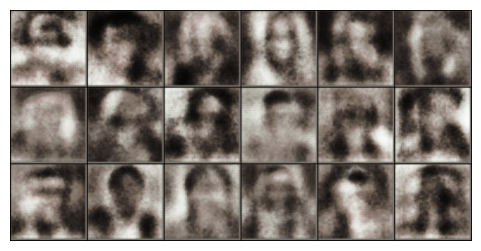

Epoch 11 | Avg Loss: 0.5673 | Recon Loss: 0.5624 | KL Div: 0.4815 | Beta: 0.0100 | Current LR: 0.000023
Epoch 12 | Avg Loss: 0.5659 | Recon Loss: 0.5609 | KL Div: 0.4944 | Beta: 0.0100 | Current LR: 0.000025
Epoch 13 | Avg Loss: 0.5641 | Recon Loss: 0.5590 | KL Div: 0.5008 | Beta: 0.0100 | Current LR: 0.000027
Epoch 14 | Avg Loss: 0.5628 | Recon Loss: 0.5577 | KL Div: 0.5075 | Beta: 0.0100 | Current LR: 0.000029
Epoch 15 | Avg Loss: 0.5609 | Recon Loss: 0.5558 | KL Div: 0.5170 | Beta: 0.0100 | Current LR: 0.000031
Epoch 16 | Avg Loss: 0.5597 | Recon Loss: 0.5545 | KL Div: 0.5236 | Beta: 0.0100 | Current LR: 0.000033
Epoch 17 | Avg Loss: 0.5583 | Recon Loss: 0.5530 | KL Div: 0.5302 | Beta: 0.0100 | Current LR: 0.000035
Epoch 18 | Avg Loss: 0.5567 | Recon Loss: 0.5514 | KL Div: 0.5372 | Beta: 0.0100 | Current LR: 0.000037
Epoch 19 | Avg Loss: 0.5563 | Recon Loss: 0.5508 | KL Div: 0.5419 | Beta: 0.0100 | Current LR: 0.000039
Epoch 20 | Avg Loss: 0.5543 | Recon Loss: 0.5488 | KL Div: 0.546

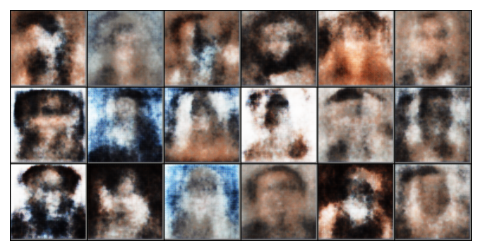

Epoch 21 | Avg Loss: 0.5539 | Recon Loss: 0.5484 | KL Div: 0.5533 | Beta: 0.0100 | Current LR: 0.000043
Epoch 22 | Avg Loss: 0.5534 | Recon Loss: 0.5478 | KL Div: 0.5584 | Beta: 0.0100 | Current LR: 0.000045
Epoch 23 | Avg Loss: 0.5521 | Recon Loss: 0.5465 | KL Div: 0.5622 | Beta: 0.0100 | Current LR: 0.000047
Epoch 24 | Avg Loss: 0.5516 | Recon Loss: 0.5459 | KL Div: 0.5671 | Beta: 0.0100 | Current LR: 0.000049
Epoch 25 | Avg Loss: 0.5509 | Recon Loss: 0.5452 | KL Div: 0.5635 | Beta: 0.0100 | Current LR: 0.000051
Epoch 26 | Avg Loss: 0.5508 | Recon Loss: 0.5451 | KL Div: 0.5709 | Beta: 0.0100 | Current LR: 0.000052
Epoch 27 | Avg Loss: 0.5501 | Recon Loss: 0.5444 | KL Div: 0.5721 | Beta: 0.0100 | Current LR: 0.000054
Epoch 28 | Avg Loss: 0.5501 | Recon Loss: 0.5444 | KL Div: 0.5725 | Beta: 0.0100 | Current LR: 0.000056
Epoch 29 | Avg Loss: 0.5492 | Recon Loss: 0.5434 | KL Div: 0.5766 | Beta: 0.0100 | Current LR: 0.000058
Epoch 30 | Avg Loss: 0.5489 | Recon Loss: 0.5431 | KL Div: 0.572

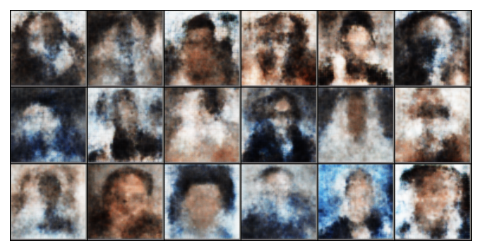

Epoch 31 | Avg Loss: 0.5489 | Recon Loss: 0.5432 | KL Div: 0.5757 | Beta: 0.0100 | Current LR: 0.000062
Epoch 32 | Avg Loss: 0.5483 | Recon Loss: 0.5426 | KL Div: 0.5753 | Beta: 0.0100 | Current LR: 0.000064
Epoch 33 | Avg Loss: 0.5482 | Recon Loss: 0.5424 | KL Div: 0.5779 | Beta: 0.0100 | Current LR: 0.000066
Epoch 34 | Avg Loss: 0.5480 | Recon Loss: 0.5422 | KL Div: 0.5819 | Beta: 0.0100 | Current LR: 0.000068
Epoch 35 | Avg Loss: 0.5479 | Recon Loss: 0.5421 | KL Div: 0.5804 | Beta: 0.0100 | Current LR: 0.000070
Epoch 36 | Avg Loss: 0.5480 | Recon Loss: 0.5422 | KL Div: 0.5787 | Beta: 0.0100 | Current LR: 0.000072
Epoch 37 | Avg Loss: 0.5478 | Recon Loss: 0.5420 | KL Div: 0.5811 | Beta: 0.0100 | Current LR: 0.000074
Epoch 38 | Avg Loss: 0.5473 | Recon Loss: 0.5415 | KL Div: 0.5823 | Beta: 0.0100 | Current LR: 0.000076
Epoch 39 | Avg Loss: 0.5466 | Recon Loss: 0.5408 | KL Div: 0.5772 | Beta: 0.0100 | Current LR: 0.000078
Epoch 40 | Avg Loss: 0.5469 | Recon Loss: 0.5411 | KL Div: 0.580

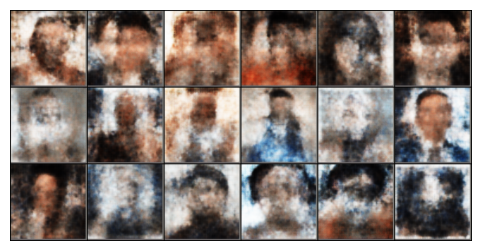

Epoch 41 | Avg Loss: 0.5466 | Recon Loss: 0.5408 | KL Div: 0.5786 | Beta: 0.0100 | Current LR: 0.000082
Epoch 42 | Avg Loss: 0.5465 | Recon Loss: 0.5407 | KL Div: 0.5793 | Beta: 0.0100 | Current LR: 0.000084
Epoch 43 | Avg Loss: 0.5466 | Recon Loss: 0.5408 | KL Div: 0.5808 | Beta: 0.0100 | Current LR: 0.000086
Epoch 44 | Avg Loss: 0.5465 | Recon Loss: 0.5407 | KL Div: 0.5810 | Beta: 0.0100 | Current LR: 0.000088
Epoch 45 | Avg Loss: 0.5468 | Recon Loss: 0.5410 | KL Div: 0.5825 | Beta: 0.0100 | Current LR: 0.000090
Epoch 46 | Avg Loss: 0.5465 | Recon Loss: 0.5408 | KL Div: 0.5772 | Beta: 0.0100 | Current LR: 0.000092
Epoch 47 | Avg Loss: 0.5462 | Recon Loss: 0.5405 | KL Div: 0.5777 | Beta: 0.0100 | Current LR: 0.000094
Epoch 48 | Avg Loss: 0.5459 | Recon Loss: 0.5401 | KL Div: 0.5810 | Beta: 0.0100 | Current LR: 0.000096
Epoch 49 | Avg Loss: 0.5465 | Recon Loss: 0.5406 | KL Div: 0.5834 | Beta: 0.0100 | Current LR: 0.000098
Epoch 50 | Avg Loss: 0.5458 | Recon Loss: 0.5400 | KL Div: 0.579

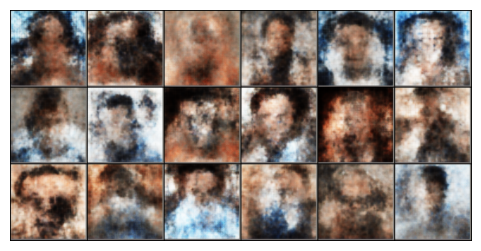

Epoch 51 | Avg Loss: 0.5459 | Recon Loss: 0.5401 | KL Div: 0.5795 | Beta: 0.0100 | Current LR: 0.000100
Epoch 52 | Avg Loss: 0.5453 | Recon Loss: 0.5394 | KL Div: 0.5854 | Beta: 0.0100 | Current LR: 0.000100
Epoch 53 | Avg Loss: 0.5452 | Recon Loss: 0.5394 | KL Div: 0.5797 | Beta: 0.0100 | Current LR: 0.000100
Epoch 54 | Avg Loss: 0.5451 | Recon Loss: 0.5393 | KL Div: 0.5835 | Beta: 0.0100 | Current LR: 0.000100
Epoch 55 | Avg Loss: 0.5444 | Recon Loss: 0.5385 | KL Div: 0.5864 | Beta: 0.0100 | Current LR: 0.000100
Epoch 56 | Avg Loss: 0.5443 | Recon Loss: 0.5385 | KL Div: 0.5820 | Beta: 0.0100 | Current LR: 0.000100
Epoch 57 | Avg Loss: 0.5438 | Recon Loss: 0.5380 | KL Div: 0.5812 | Beta: 0.0100 | Current LR: 0.000100
Epoch 58 | Avg Loss: 0.5440 | Recon Loss: 0.5382 | KL Div: 0.5838 | Beta: 0.0100 | Current LR: 0.000100
Epoch 59 | Avg Loss: 0.5435 | Recon Loss: 0.5377 | KL Div: 0.5853 | Beta: 0.0100 | Current LR: 0.000100
Epoch 60 | Avg Loss: 0.5435 | Recon Loss: 0.5376 | KL Div: 0.584

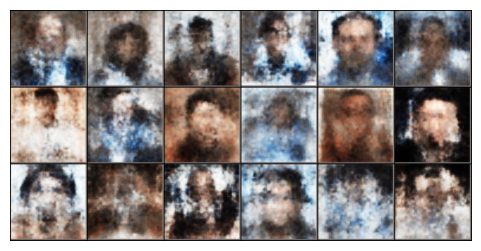

Epoch 61 | Avg Loss: 0.5429 | Recon Loss: 0.5370 | KL Div: 0.5855 | Beta: 0.0100 | Current LR: 0.000100
Epoch 62 | Avg Loss: 0.5426 | Recon Loss: 0.5367 | KL Div: 0.5879 | Beta: 0.0100 | Current LR: 0.000100
Epoch 63 | Avg Loss: 0.5424 | Recon Loss: 0.5365 | KL Div: 0.5872 | Beta: 0.0100 | Current LR: 0.000100
Epoch 64 | Avg Loss: 0.5422 | Recon Loss: 0.5363 | KL Div: 0.5857 | Beta: 0.0100 | Current LR: 0.000100
Epoch 65 | Avg Loss: 0.5420 | Recon Loss: 0.5361 | KL Div: 0.5898 | Beta: 0.0100 | Current LR: 0.000100
Epoch 66 | Avg Loss: 0.5418 | Recon Loss: 0.5359 | KL Div: 0.5889 | Beta: 0.0100 | Current LR: 0.000100
Epoch 67 | Avg Loss: 0.5417 | Recon Loss: 0.5358 | KL Div: 0.5920 | Beta: 0.0100 | Current LR: 0.000100
Epoch 68 | Avg Loss: 0.5416 | Recon Loss: 0.5357 | KL Div: 0.5894 | Beta: 0.0100 | Current LR: 0.000100
Epoch 69 | Avg Loss: 0.5414 | Recon Loss: 0.5355 | KL Div: 0.5901 | Beta: 0.0100 | Current LR: 0.000100
Epoch 70 | Avg Loss: 0.5411 | Recon Loss: 0.5352 | KL Div: 0.591

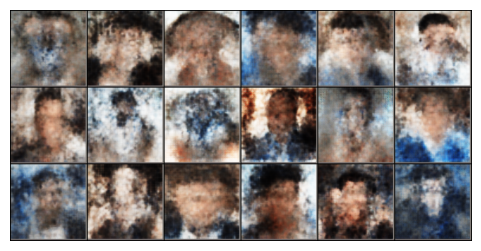

Epoch 71 | Avg Loss: 0.5405 | Recon Loss: 0.5346 | KL Div: 0.5893 | Beta: 0.0100 | Current LR: 0.000100
Epoch 72 | Avg Loss: 0.5405 | Recon Loss: 0.5345 | KL Div: 0.5927 | Beta: 0.0100 | Current LR: 0.000100
Epoch 73 | Avg Loss: 0.5402 | Recon Loss: 0.5343 | KL Div: 0.5944 | Beta: 0.0100 | Current LR: 0.000100
Epoch 74 | Avg Loss: 0.5396 | Recon Loss: 0.5337 | KL Div: 0.5912 | Beta: 0.0100 | Current LR: 0.000100
Epoch 75 | Avg Loss: 0.5396 | Recon Loss: 0.5337 | KL Div: 0.5892 | Beta: 0.0100 | Current LR: 0.000100
Epoch 76 | Avg Loss: 0.5393 | Recon Loss: 0.5333 | KL Div: 0.5935 | Beta: 0.0100 | Current LR: 0.000100
Epoch 77 | Avg Loss: 0.5394 | Recon Loss: 0.5334 | KL Div: 0.5942 | Beta: 0.0100 | Current LR: 0.000100
Epoch 78 | Avg Loss: 0.5393 | Recon Loss: 0.5334 | KL Div: 0.5942 | Beta: 0.0100 | Current LR: 0.000100
Epoch 79 | Avg Loss: 0.5384 | Recon Loss: 0.5325 | KL Div: 0.5957 | Beta: 0.0100 | Current LR: 0.000100
Epoch 80 | Avg Loss: 0.5387 | Recon Loss: 0.5328 | KL Div: 0.596

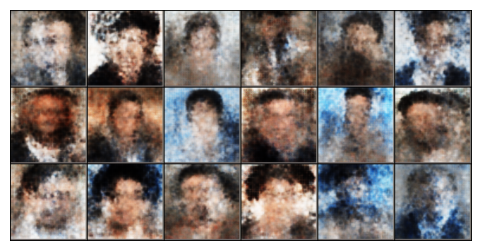

Epoch 81 | Avg Loss: 0.5383 | Recon Loss: 0.5324 | KL Div: 0.5937 | Beta: 0.0100 | Current LR: 0.000100
Epoch 82 | Avg Loss: 0.5378 | Recon Loss: 0.5318 | KL Div: 0.5963 | Beta: 0.0100 | Current LR: 0.000100
Epoch 83 | Avg Loss: 0.5383 | Recon Loss: 0.5324 | KL Div: 0.5947 | Beta: 0.0100 | Current LR: 0.000100
Epoch 84 | Avg Loss: 0.5377 | Recon Loss: 0.5317 | KL Div: 0.5952 | Beta: 0.0100 | Current LR: 0.000100
Epoch 85 | Avg Loss: 0.5378 | Recon Loss: 0.5318 | KL Div: 0.5990 | Beta: 0.0100 | Current LR: 0.000100
Epoch 86 | Avg Loss: 0.5375 | Recon Loss: 0.5315 | KL Div: 0.5988 | Beta: 0.0100 | Current LR: 0.000100
Epoch 87 | Avg Loss: 0.5375 | Recon Loss: 0.5315 | KL Div: 0.5961 | Beta: 0.0100 | Current LR: 0.000100
Epoch 88 | Avg Loss: 0.5371 | Recon Loss: 0.5311 | KL Div: 0.5962 | Beta: 0.0100 | Current LR: 0.000100
Epoch 89 | Avg Loss: 0.5370 | Recon Loss: 0.5310 | KL Div: 0.6011 | Beta: 0.0100 | Current LR: 0.000100
Epoch 90 | Avg Loss: 0.5365 | Recon Loss: 0.5305 | KL Div: 0.598

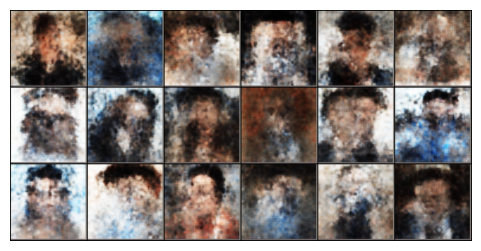

Epoch 91 | Avg Loss: 0.5366 | Recon Loss: 0.5307 | KL Div: 0.5978 | Beta: 0.0100 | Current LR: 0.000100
Epoch 92 | Avg Loss: 0.5364 | Recon Loss: 0.5304 | KL Div: 0.6013 | Beta: 0.0100 | Current LR: 0.000100
Epoch 93 | Avg Loss: 0.5363 | Recon Loss: 0.5303 | KL Div: 0.6007 | Beta: 0.0100 | Current LR: 0.000100
Epoch 94 | Avg Loss: 0.5362 | Recon Loss: 0.5302 | KL Div: 0.5978 | Beta: 0.0100 | Current LR: 0.000100
Epoch 95 | Avg Loss: 0.5364 | Recon Loss: 0.5304 | KL Div: 0.6009 | Beta: 0.0100 | Current LR: 0.000100
Epoch 96 | Avg Loss: 0.5358 | Recon Loss: 0.5298 | KL Div: 0.5988 | Beta: 0.0100 | Current LR: 0.000100
Epoch 97 | Avg Loss: 0.5357 | Recon Loss: 0.5297 | KL Div: 0.6011 | Beta: 0.0100 | Current LR: 0.000100
Epoch 98 | Avg Loss: 0.5355 | Recon Loss: 0.5295 | KL Div: 0.5998 | Beta: 0.0100 | Current LR: 0.000100
Epoch 99 | Avg Loss: 0.5357 | Recon Loss: 0.5296 | KL Div: 0.6041 | Beta: 0.0100 | Current LR: 0.000100


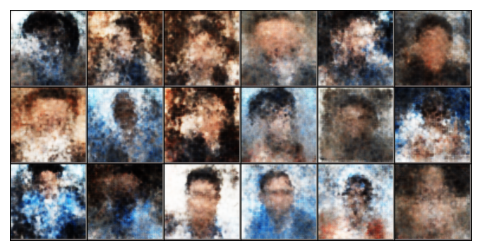

Training completed. Saving model...


In [12]:
# ==========================================================================
# ####### MODEL TRAINING (EXCECUTE ONLY IF RE-TRAINING IS NECESSARY) #######
# ==========================================================================

MLFLOW_TRACKING = True # Recording in MLFlow

if MLFLOW_TRACKING:
      
      mlflow.set_experiment(EXPERIMENT_NAME)

      with mlflow.start_run(run_name=RUN_NAME):
            print("Logging parameters to MLFlow...")
            mlflow.log_param('learning_rate', HP_LR)
            mlflow.log_param('patience', HP_PATIENCE)
            mlflow.log_param('n_epochs', HP_N_EPOCHS)
            mlflow.log_param('max_beta', HP_MAX_BETA)
            mlflow.log_param('batch_size', HP_BATCH_SIZE)
            mlflow.log_param('latent_dims', HP_LATENT_DIMS)
            mlflow.log_param('start_factor', HP_START_FACTOR)
            mlflow.log_param('weight_decay', HP_WEIGHT_DECAY)
            mlflow.log_param('kl_threshold', HP_KL_THRESHOLD)
            mlflow.log_param('warmup_epochs', HP_WARMUP_EPOCHS)
            mlflow.log_param('beta_annealing', HP_BETA_ANNEALING)
            mlflow.log_param('architecture', HP_MODEL_ARCH)
            mlflow.log_param('loss_function', HP_LOSS_FCN)
            mlflow.log_param('optimizer', "Adam")
            mlflow.log_param('scheduler', "ReduceLROnPlateau")

            print(f"Starting MLFlow Run: {mlflow.active_run().info.run_name}")

            for epoch in range(HP_N_EPOCHS):
                beta = HP_MAX_BETA * min(1.0, (epoch / HP_BETA_ANNEALING)) # Strength of KL regularization for Beta-VAE model
                avg_loss, avg_recon, avg_kl = train_epoch(beta, HP_KL_THRESHOLD, vae, men_loader, optimizer, HP_LOSS_FCN)
                current_lr = optimizer.param_groups[0]['lr'] # Current learning rate on optimizer

                print(f"Epoch {epoch} | Avg Loss: {avg_loss:.4f} | Recon Loss: {avg_recon:.4f} | KL Div: {avg_kl:.4f} | Beta: {beta:.4f} | Current LR: {current_lr:.6f}")

                mlflow.log_metric('avg_loss', avg_loss, step=epoch)
                mlflow.log_metric('recon_loss', avg_recon, step=epoch)
                mlflow.log_metric('kl_div', avg_kl, step=epoch)
                mlflow.log_metric('learning_rate', current_lr, step=epoch)

                if epoch < HP_WARMUP_EPOCHS:
                      # Warm-up phase
                      scheduler_warmup.step()
                else:
                      # After-Warm-up phase:
                      scheduler_main.step(avg_loss)

                if epoch % 10 == 0 or epoch == HP_N_EPOCHS - 1:
                        
                        # Save the image:
                        plots_filename = f"../reports/figures/vae/epoch_{epoch}.png"

                        # Call plot function:
                        plot_epoch(save_path=plots_filename, latent_dims=HP_LATENT_DIMS, vae_model=vae)

                        mlflow.log_artifact(plots_filename, "plots") # Record on MLFlow
                        os.remove(plots_filename) # Remove temporal image from repo

            # Saving the trained model:
            print("Training completed. Saving model...")
            model_filename = "../models/vae_UTKFace.pth"
            torch.save(vae.state_dict(), model_filename)
            mlflow.log_artifact(model_filename, 'model')

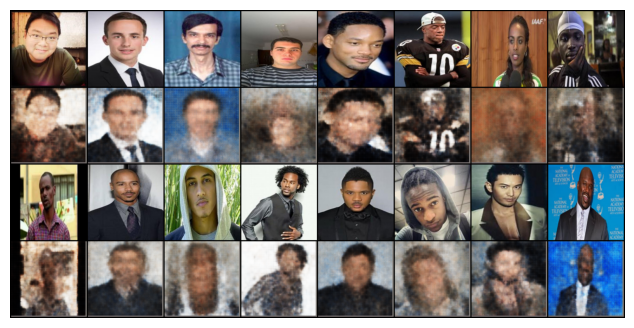

In [13]:
# Generating images using the trained model:
vae.eval()

with torch.no_grad():
    vae.load_state_dict(torch.load("../models/vae_UTKFace.pth", map_location=device))
    imgs, _ = next(iter(men_loader)) # Get a batch of images
    imgs = imgs.to(device)
    recon_imgs, mu, log_var = vae(imgs) # Forward pass through VAE

    # Concatenate the original and reconstructed images:
    images = torch.cat([
        imgs[:8].detach().cpu(),
        recon_imgs[:8].detach().cpu(),
        imgs[8:16].detach().cpu(),
        recon_imgs[8:16].detach().cpu()
    ], dim=0)

    images = torchvision.utils.make_grid(images, 8, 4)
    fig, ax = plt.subplots(figsize=(8, 4), dpi=100)
    plt.imshow(np.transpose(images.numpy(), (1, 2, 0)))
    plt.axis("off")

    # Save image reconstruction:
    img_recon_path = f"../reports/figures/vae/vae_reconstruction.png"
    plt.savefig(img_recon_path, bbox_inches='tight')
    plt.show()

# Encoding Arithmetic with VAE